# DEEPFASHION

In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.ResNet50 import ResNet50
#from keras.applications.ResNet50 import preprocess_input

/home/vevdokimov11/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMG_SIZE = (200, 300)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
from random import shuffle
from glob import glob

train_files = glob('../../data/Consumer-to-shop Clothes Retrieval/img/*/*/*/*.jpg')
#test_files = glob('./data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            target = []
            for path in files[i:j]:
                if re.search('DRESSES', path):
                    target.append([1, 0, 0])
                elif re.search('TOPS', path):
                    target.append([0, 1, 0])
                else:
                    target.append([0, 0, 1])
            y = np.array(target)
            yield (x, y)

## Визуализируем примеры для обучения

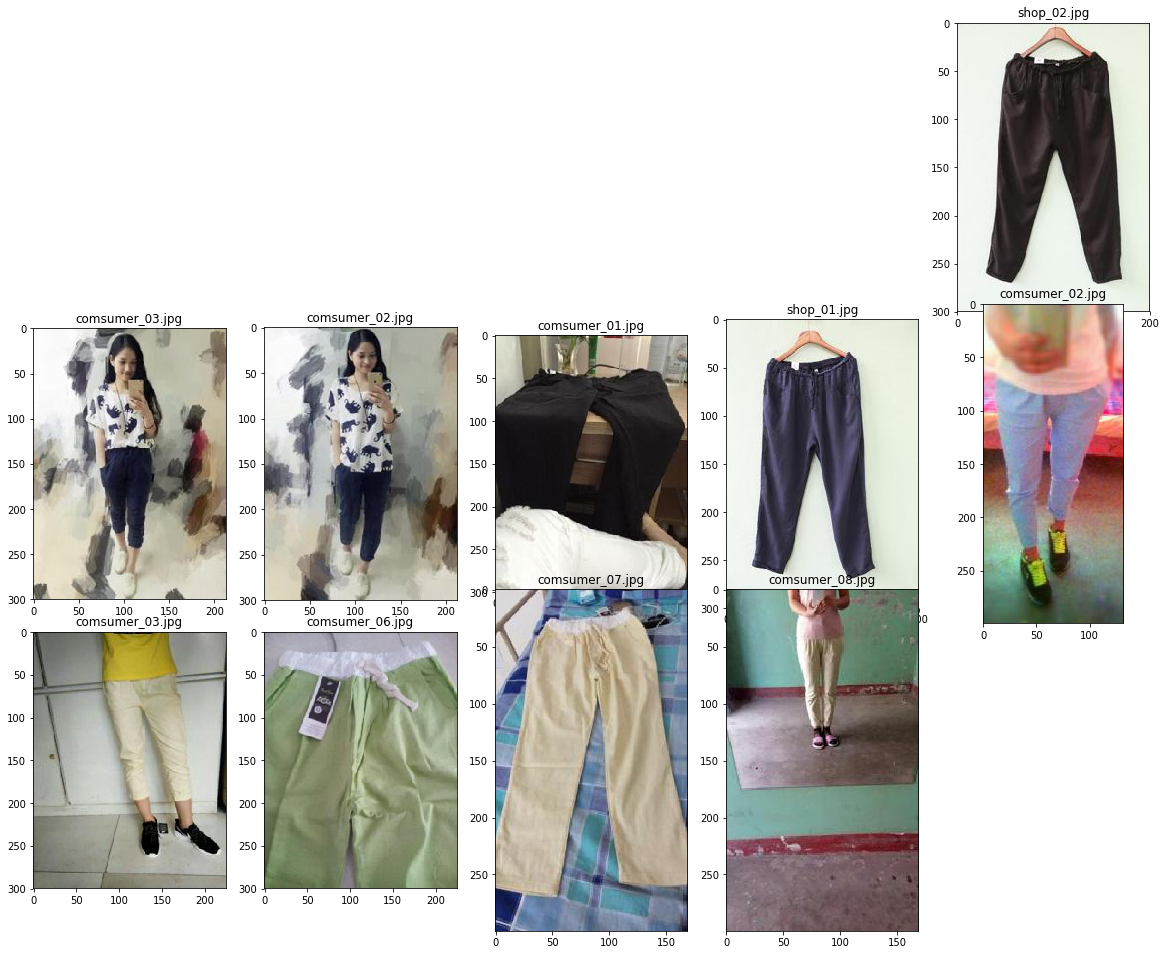

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [5]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [7]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

## Добавляем полносвязный слой

In [8]:
x = base_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3,  # 4 выхода
                activation='softmax',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [10]:
# оределяем веса классов
k1 = 0
k2 = 0
k3 = 0
for path in train_files:
    if re.search('DRESSES', path):
        k1 = k1 + 1
    elif re.search('TOPS', path):
        k2 = k2 + 1
    else:
        k3 = k3 +1
k_sum = k1 + k2 + k3
k1 = k1 / k_sum 
k2 = k2 / k_sum
k3 = k3 / k_sum

<Container object of 3 artists>

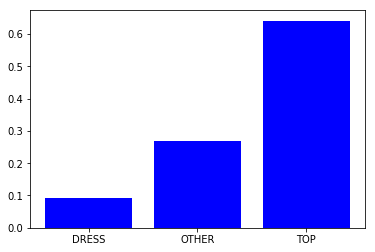

In [11]:
import plotly.plotly as py
plt.bar( ['DRESS','TOP','OTHER'] ,[k1*k_sum, k2*k_sum, k3*k_sum], color="blue")

In [12]:
weights = np.array([k1, k2, k3]) #веса классов
weights

array([0.09108897, 0.6409581 , 0.26795293])

In [13]:
"""
weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [14]:
model.compile(optimizer = 'adam', 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])

In [16]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 500  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=50,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 176s 18s/step - loss: 1.2476 - acc: 0.6625 - val_loss: 1.3260 - val_acc: 0.6460
Epoch 2/50
10/10 [==============================] - 171s 17s/step - loss: 1.4040 - acc: 0.6344 - val_loss: 1.3256 - val_acc: 0.6460
Epoch 3/50
10/10 [==============================] - 172s 17s/step - loss: 1.2914 - acc: 0.6437 - val_loss: 1.3242 - val_acc: 0.6460
Epoch 4/50
10/10 [==============================] - 170s 17s/step - loss: 1.3705 - acc: 0.6437 - val_loss: 1.3232 - val_acc: 0.6460
Epoch 5/50
10/10 [==============================] - 171s 17s/step - loss: 1.2623 - acc: 0.6500 - val_loss: 1.3222 - val_acc: 0.6460
Epoch 6/50
10/10 [==============================] - 172s 17s/step - loss: 1.2380 - acc: 0.6781 - val_loss: 1.3214 - val_acc: 0.6460
Epoch 7/50
10/10 [==============================] - 173s 17s/step - loss: 1.3324 - acc: 0.6375 - val_loss: 1.3206 - val_acc: 0.6460
Epoch 8/50
10/10 [==============================] - 172s 17s/step - loss: 1.

KeyboardInterrupt: 

In [17]:
model.save('vgg16_15epoch')

## Обучаем внутренние слои 17,16,115,   13,12,11,    9,8,7,   5,4,    2,1

In [21]:
for layer in model.layers:
    layer.trainable = False
model.layers[17].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [22]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=50,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 174s 17s/step - loss: 1.2636 - acc: 0.6625 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/50
10/10 [==============================] - 173s 17s/step - loss: 1.3133 - acc: 0.6469 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/50
10/10 [==============================] - 172s 17s/step - loss: 1.2860 - acc: 0.6594 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/50
10/10 [==============================] - 172s 17s/step - loss: 1.2236 - acc: 0.6594 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/50
10/10 [==============================] - 172s 17s/step - loss: 1.2595 - acc: 0.6531 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 6/50
10/10 [==============================] - 172s 17s/step - loss: 1.3087 - acc: 0.6500 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 7/50
10/10 [==============================] - 173s 17s/step - loss: 1.3899 - acc: 0.6250 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 8/50
10/10 [==============================] - 175s 18s/step - loss: 1.

KeyboardInterrupt: 

In [23]:
model.save('vgg16_17_layer')

In [24]:
for layer in model.layers:
    layer.trainable = False
model.layers[16].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [25]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/5
10/10 [==============================] - 174s 17s/step - loss: 1.3581 - acc: 0.6406 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/5
10/10 [==============================] - 175s 17s/step - loss: 1.0935 - acc: 0.6813 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/5
10/10 [==============================] - 175s 17s/step - loss: 1.3087 - acc: 0.6500 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/5
10/10 [==============================] - 174s 17s/step - loss: 1.3311 - acc: 0.6469 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/5
10/10 [==============================] - 174s 17s/step - loss: 1.3764 - acc: 0.6281 - val_loss: 1.3156 - val_acc: 0.6460


In [26]:
model.save('vgg16_16_layer')

In [27]:
for layer in model.layers:
    layer.trainable = False
model.layers[15].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [28]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/5
10/10 [==============================] - 179s 18s/step - loss: 1.4609 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/5
10/10 [==============================] - 177s 18s/step - loss: 1.3899 - acc: 0.6250 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/5
10/10 [==============================] - 177s 18s/step - loss: 1.3224 - acc: 0.6406 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/5
10/10 [==============================] - 179s 18s/step - loss: 1.3135 - acc: 0.6406 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/5
10/10 [==============================] - 178s 18s/step - loss: 1.3986 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460


In [29]:
model.save('vgg16_15_layer')

### 13,12,11

In [30]:
for layer in model.layers:
    layer.trainable = False
model.layers[13].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [31]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 187s 19s/step - loss: 1.3672 - acc: 0.6344 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/10
10/10 [==============================] - 184s 18s/step - loss: 1.3130 - acc: 0.6531 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/10
10/10 [==============================] - 184s 18s/step - loss: 1.4083 - acc: 0.6125 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/10
10/10 [==============================] - 184s 18s/step - loss: 1.4172 - acc: 0.6125 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/10
10/10 [==============================] - 183s 18s/step - loss: 1.2182 - acc: 0.6813 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 6/10
10/10 [==============================] - 183s 18s/step - loss: 1.2909 - acc: 0.6500 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 7/10
10/10 [==============================] - 184s 18s/step - loss: 1.3807 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 8/10
10/10 [==============================] - 184s 18s/step - loss: 1.

In [32]:
model.save('vgg16_13_layer')

In [33]:
for layer in model.layers:
    layer.trainable = False
model.layers[12].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [34]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 193s 19s/step - loss: 1.2771 - acc: 0.6594 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/10
10/10 [==============================] - 191s 19s/step - loss: 1.1791 - acc: 0.6594 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/10
10/10 [==============================] - 192s 19s/step - loss: 1.2012 - acc: 0.6625 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/10
10/10 [==============================] - 191s 19s/step - loss: 1.2104 - acc: 0.6562 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/10
10/10 [==============================] - 191s 19s/step - loss: 1.1383 - acc: 0.6750 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 6/10
10/10 [==============================] - 192s 19s/step - loss: 1.4121 - acc: 0.6281 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 7/10
10/10 [==============================] - 192s 19s/step - loss: 1.4396 - acc: 0.6094 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 8/10
10/10 [==============================] - 191s 19s/step - loss: 1.

In [35]:
model.save('vgg16_12_layer')

In [36]:
for layer in model.layers:
    layer.trainable = False
model.layers[11].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [37]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 197s 20s/step - loss: 1.2455 - acc: 0.6688 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/10
10/10 [==============================] - 195s 20s/step - loss: 1.3313 - acc: 0.6406 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/10
10/10 [==============================] - 195s 20s/step - loss: 1.4447 - acc: 0.5938 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/10
10/10 [==============================] - 195s 19s/step - loss: 1.4034 - acc: 0.6219 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/10
10/10 [==============================] - 195s 19s/step - loss: 1.3986 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 6/10
10/10 [==============================] - 195s 19s/step - loss: 1.3130 - acc: 0.6531 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 7/10
10/10 [==============================] - 195s 19s/step - loss: 1.3805 - acc: 0.6375 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 8/10
10/10 [==============================] - 195s 19s/step - loss: 1.

In [38]:
model.save('vgg16_11_layer')

### 9, 8, 7

In [39]:
for layer in model.layers:
    layer.trainable = False
model.layers[9].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [40]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 206s 21s/step - loss: 1.4531 - acc: 0.6063 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/10
10/10 [==============================] - 208s 21s/step - loss: 1.2056 - acc: 0.6656 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/10
10/10 [==============================] - 207s 21s/step - loss: 1.2641 - acc: 0.6500 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/10
10/10 [==============================] - 208s 21s/step - loss: 1.2142 - acc: 0.6719 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/10
10/10 [==============================] - 208s 21s/step - loss: 1.2593 - acc: 0.6594 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 6/10
10/10 [==============================] - 209s 21s/step - loss: 1.4882 - acc: 0.6188 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 7/10
10/10 [==============================] - 206s 21s/step - loss: 1.3087 - acc: 0.6500 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 8/10
10/10 [==============================] - 206s 21s/step - loss: 1.

In [41]:
model.save('vgg16_9_layer')

In [42]:
for layer in model.layers:
    layer.trainable = False
model.layers[8].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [43]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/5
10/10 [==============================] - 216s 22s/step - loss: 1.3805 - acc: 0.6375 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/5
10/10 [==============================] - 214s 21s/step - loss: 1.4164 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/5
10/10 [==============================] - 214s 21s/step - loss: 1.4976 - acc: 0.6063 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/5
10/10 [==============================] - 216s 22s/step - loss: 1.4436 - acc: 0.6188 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/5
10/10 [==============================] - 218s 22s/step - loss: 1.4083 - acc: 0.6125 - val_loss: 1.3156 - val_acc: 0.6460


In [44]:
model.save('vgg16_8_layer')

In [45]:
for layer in model.layers:
    layer.trainable = False
model.layers[7].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [46]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=5,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/5
5/5 [==============================] - 165s 33s/step - loss: 1.4158 - acc: 0.6437 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/5
5/5 [==============================] - 162s 32s/step - loss: 1.4067 - acc: 0.6500 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/5
5/5 [==============================] - 162s 32s/step - loss: 1.1837 - acc: 0.6562 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/5
5/5 [==============================] - 161s 32s/step - loss: 1.4266 - acc: 0.6000 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/5
5/5 [==============================] - 162s 32s/step - loss: 1.4342 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460


In [47]:
model.save('vgg16_7_layer')

### 5, 4, 2, 1

In [48]:
for layer in model.layers:
    layer.trainable = False
model.layers[5].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [49]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=5,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/5
5/5 [==============================] - 170s 34s/step - loss: 1.3629 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/5
5/5 [==============================] - 168s 34s/step - loss: 1.1745 - acc: 0.6625 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 3/5
5/5 [==============================] - 168s 34s/step - loss: 1.2998 - acc: 0.6500 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 4/5
5/5 [==============================] - 169s 34s/step - loss: 1.3451 - acc: 0.6312 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 5/5
5/5 [==============================] - 169s 34s/step - loss: 1.3716 - acc: 0.6375 - val_loss: 1.3156 - val_acc: 0.6460


In [50]:
model.save('vgg16_5_layer')

In [ ]:
for layer in model.layers:
    layer.trainable = False
model.layers[4].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 75, 128)       0         
__________

In [ ]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=5,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/5
5/5 [==============================] - 174s 35s/step - loss: 1.5524 - acc: 0.5750 - val_loss: 1.3156 - val_acc: 0.6460
Epoch 2/5


In [ ]:
model.save('vgg16_4_layer')

In [ ]:
for layer in model.layers:
    layer.trainable = False
model.layers[2].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

In [ ]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=5,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

In [ ]:
model.save('vgg16_2_layer')

In [ ]:
for layer in model.layers:
    layer.trainable = False
model.layers[1].trainable = True

model.compile(optimizer = SGD(lr=0.0001, momentum=0.9), 
              loss = weighted_categorical_crossentropy(weights),  # функция потерь 
              metrics = ['accuracy'])
model.summary()

In [ ]:
# запускаем обучение оставшихся слоев
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=5,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

In [ ]:
model.save('vgg16_1_layer')

In [19]:
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [20]:
pred = model.predict_generator(predict_generator(train_files[:10]), 
                               len(train_files[:10]), max_queue_size=500)

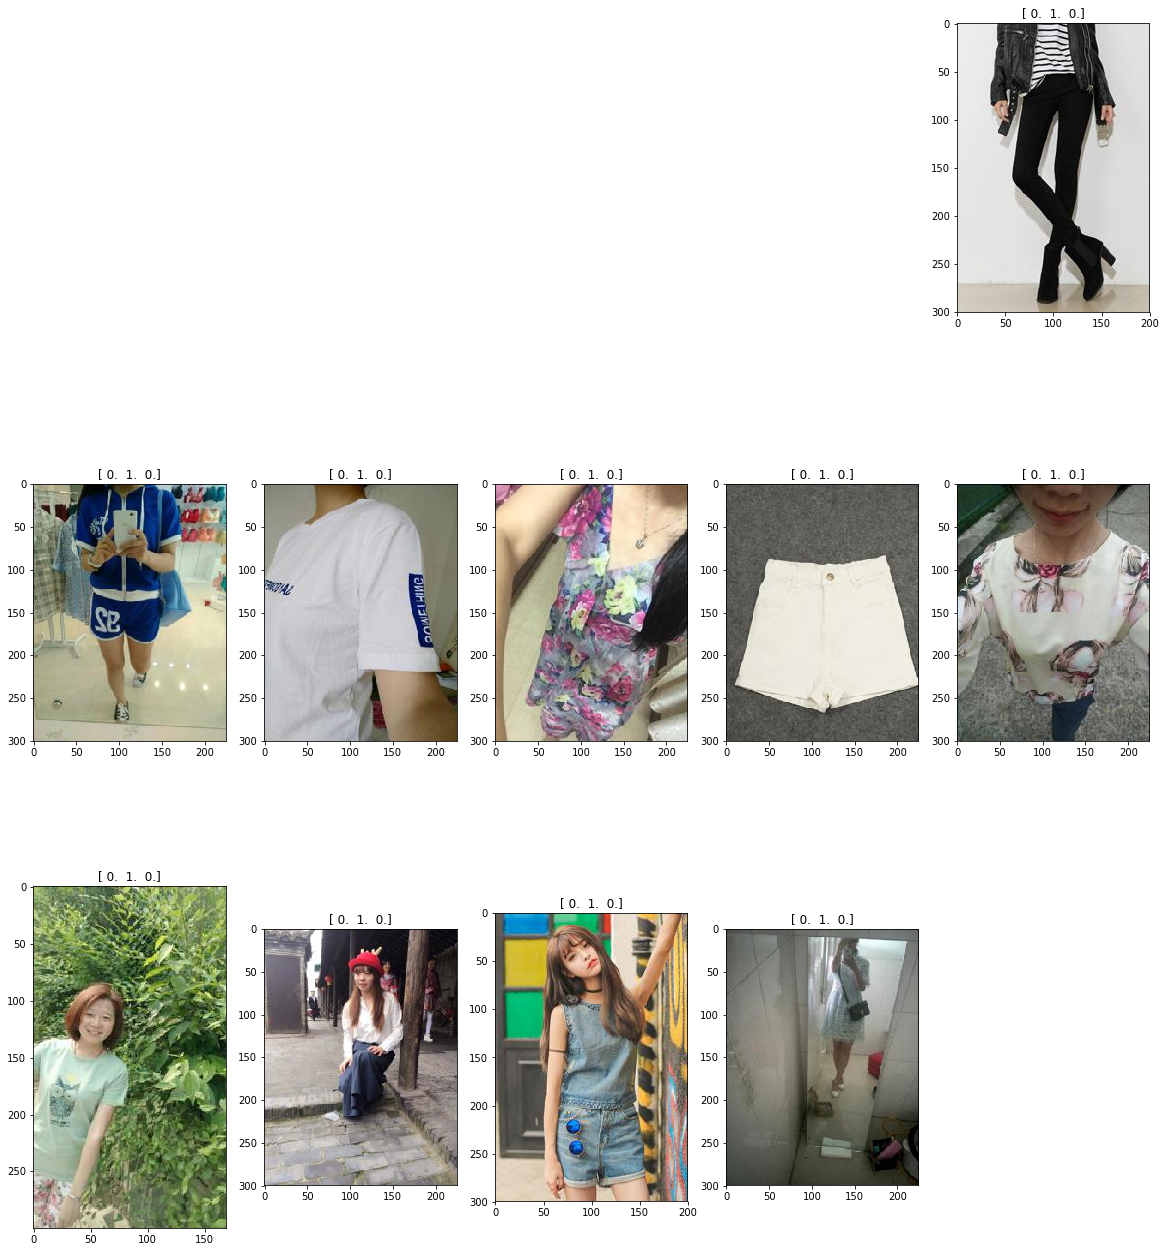

In [21]:
fig = plt.figure(figsize=(20, 30))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title(pred[i-1]);
